In [97]:
import pandas as pd 
import datetime as dt

import matplotlib.pyplot as plt

In [98]:
df_history = (pd.read_csv('./nettoshortpositieshistorie.csv', sep=';', encoding='latin')
        .dropna()
        .assign(datum=lambda d: d['Positiedatum'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d 00:00:00'))))


In [99]:
df_current = (pd.read_csv('./nettoshortpositiesactueel.csv', sep=';', encoding='latin')
              .dropna()
              .assign(datum=lambda d: d['Positiedatum'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d 00:00:00')))
             )

In [5]:
df_current.columns

Index(['Positie houder', 'Naam van de emittent', 'ISIN', 'Netto Shortpositie',
       'Positiedatum', 'datum'],
      dtype='object')

In [6]:
df = pd.concat([df_history, df_current])

# Dutch data on short selling

In [443]:
def total_short(emittent):
    history = short_history(emittent).sum(axis=1)
    current = current_short(emittent).sum(axis=1)
    return pd.DataFrame(history.add(current, fill_value=0), columns=['Total netto short position'])

def plot_total_short(emittent, ax=None, min_date=None, max_date=None):
    
    total = total_short(emittent)

    if min_date:
        total = total[total.index >= min_date]
        
    if max_date:
        days_to_max_date = pd.date_range(max(total.index), end=max_date)  
        empty_series = pd.DataFrame(np.zeros(len(days_to_max_date)), 
                                    days_to_max_date, 
                                    columns=['Total netto short position'])
        total = pd.concat([total, empty_series])[:max_date]
    
    total.plot(figsize=(15, 8), ax=ax, color='tab:red', linestyle='--', ylim=0.0)

In [444]:
def current_short(emittent):

    return (df_current [df_current['Naam van de emittent'] == emittent]
        .pivot_table(index='datum', values='Netto Shortpositie', columns="Positie houder")
        .sort_values('datum')
        .reset_index()
        .groupby(pd.Grouper(key="datum", freq='D')).max().fillna(method='ffill')
        .fillna(0))

def plot_current_short(emittent):

    current_short(emittent).sum(axis=1).plot(title=f"Current short position in {emittent}")
    

def short_history(emittent):
    return (df_history[df_history['Naam van de emittent'] == emittent]
            .pivot_table(index='datum', values='Netto Shortpositie', columns="Positie houder")
            .reset_index()
            .groupby(pd.Grouper(key="datum", freq='D', )).max()
            .apply(lambda x: x.loc[:x.last_valid_index()].ffill())
            .fillna(0)) 

def plot_history_short(emittent):
    
    short_history(emittent).sum(axis=1).plot(figsize=(20, 10))

# Read Stock prices

In [445]:
def read_stock_data(company: str):
    return (pd.read_csv(f'{company}_quote_chart.csv', sep=',')
        .assign(date=lambda d: d['time']
        .apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:00')))
        [[company, 'date']]
        .rename(columns={company: 'Stock price'})
         )



def plot_stock_data(company, min_date, max_date, ax=None):
    df_ft = read_stock_data(company)

    (df_ft[(df_ft['date'] >= min_date) & (df_ft['date'] <= max_date)]
        .groupby(pd.Grouper(key="date", freq='D',))
        .max()
        .bfill()
        .plot(figsize=(15, 8), ax=ax, color='tab:blue', ylim=0))

## Flow traders

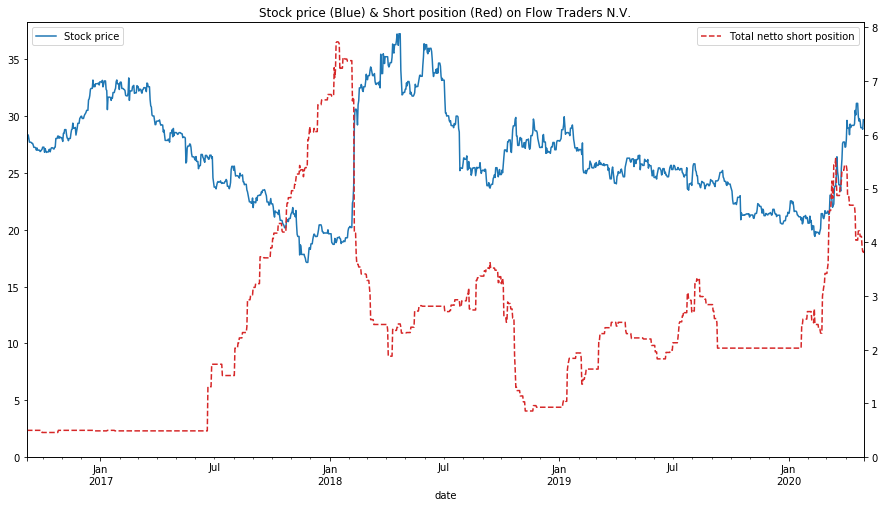

In [446]:
fig, ax1 = plt.subplots()

emittent = "Flow Traders N.V."
company = "FLOW TRADERS"

df_ft_short = total_short(emittent)

plot_stock_data(company, min(df_ft_short.index), max(df_ft_short.index), ax=ax1)
ax1.legend(loc='upper left')
ax1.set_title(f"Stock price (Blue) & Short position (Red) on {emittent}")

ax2 = ax1.twinx()
plot_total_short(emittent, ax=ax2)
ax2.legend(loc='upper right')

plt.show()

## Post NL

In [413]:
def plot_stock_and_short(emittent:str, company: str):
    
    fig, ax1 = plt.subplots()
    
    min_date = pd.Timestamp(2019, 11, 1)
    max_date = pd.Timestamp(2020, 4, 30)

    df_short = total_short(emittent)

    plot_stock_data(company, min_date, max_date, ax=ax1)
    ax1.legend(loc='upper left')
    ax1.set_title(f"{emittent}", fontdict={'fontsize': 20})

    ax2 = ax1.twinx()
    plot_total_short(emittent, ax=ax2, min_date=min_date, max_date=max_date)
    ax2.legend(loc='upper right')

    plt.show()

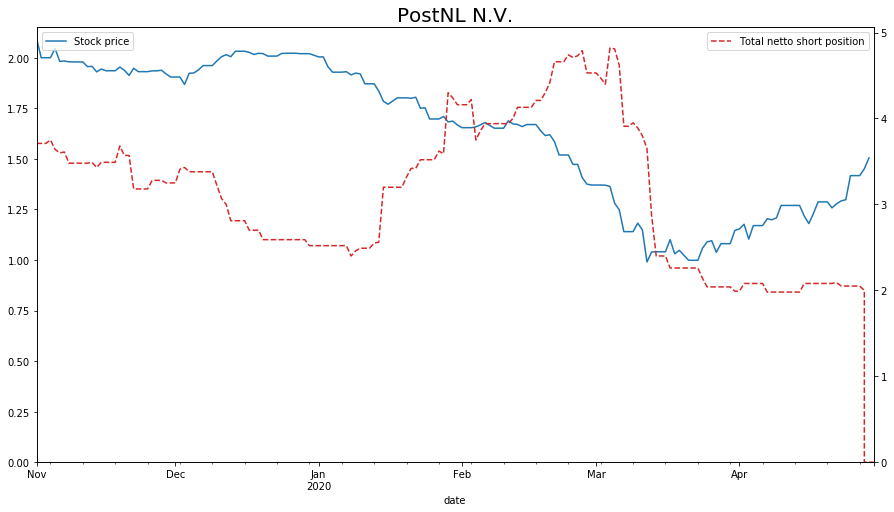

In [447]:
emittent = "PostNL N.V."
company = "POSTNL"

plot_stock_and_short(emittent, company)

## BPOST

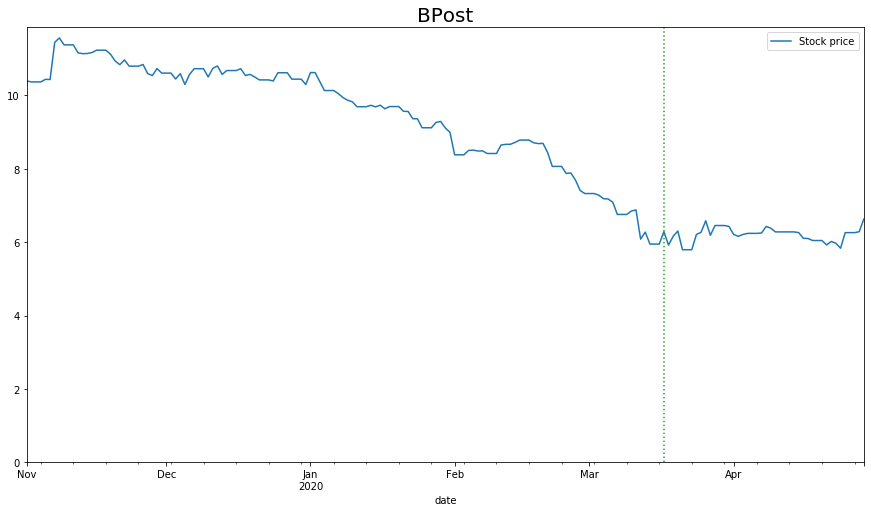

In [448]:
company = "BPOST"
emittent = "BPost"

fig, ax1 = plt.subplots()

ax1.set_title(f"{emittent}", fontdict={'fontsize': 20})

min_date = pd.Timestamp(2019, 11, 1)
max_date = pd.Timestamp(2020, 4, 30)

plot_stock_data(company, min_date, max_date, ax=ax1)

ax2 = plt.axvline(pd.Timestamp(2020, 3, 17), color='tab:green', linestyle='dotted')

## KPN

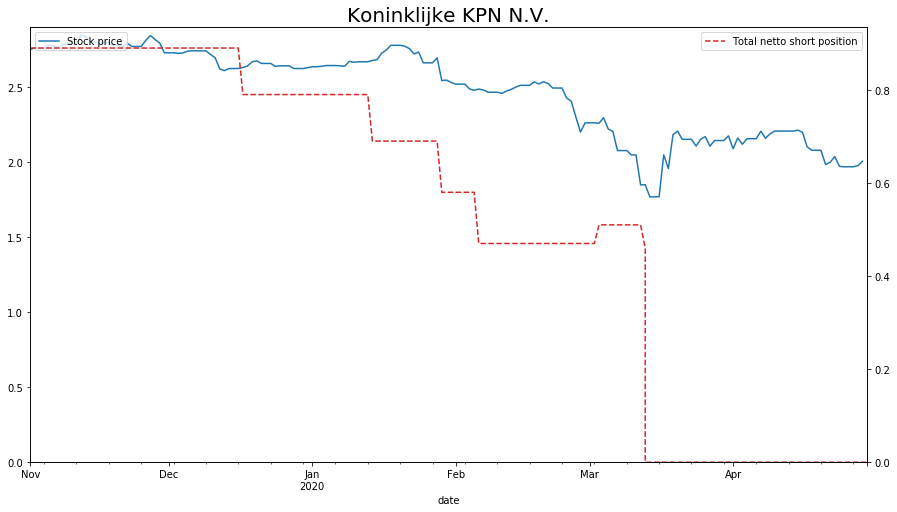

In [449]:
emittent = "Koninklijke KPN N.V."
company = "KPN KON"

plot_stock_and_short(emittent, company)

Read data from FSMA

## Proximus

In [453]:
df_proximus = (pd.read_csv('disclosure_net_short_positions_-_fsma_proximus.csv', sep=';', header=None)
              .assign(date=lambda d: d[4].apply(lambda x: dt.datetime.strptime(x, '%d/%m/%Y')))
              .assign(netto_short= lambda d: d[3].apply(lambda x: float(x[:4].replace(',', '.').split(' ')[0])))
              )

def plot_short_fsma(min_date, max_date, ax):
    
    df_short = (df_proximus[['date', 'netto_short']]
         .rename(columns={'netto_short': 'Total netto short position'})
         [df_proximus['date'] >= min_date]
         .groupby('date')
         .sum())
    # Make sure the plot starts from 0: TODO ugly fix
    df_short.loc[min(df_short.index) - pd.DateOffset(1)] = 0.0
    df_short.loc[min_date] = 0.0 
    df_short.loc[max(df_short.index) + pd.DateOffset(1)] = 0.0
    df_short.loc[max_date] = 0.0
    
    df_short.sort_values('date').plot(figsize=(15, 8), ylim=0.0, ax=ax, linestyle='--', color="tab:red")

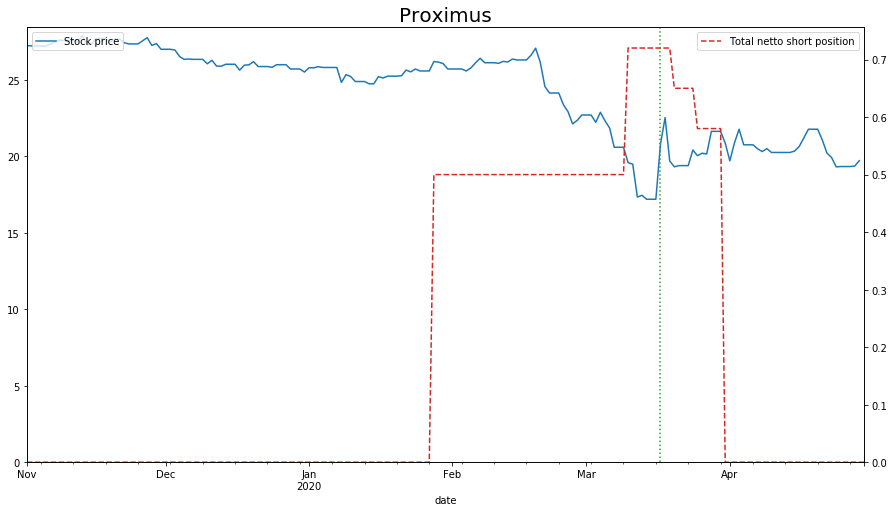

In [454]:
company = "PROXIMUS"
emittent = "Proximus"

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.set_title(f"{emittent}", fontdict={'fontsize': 20})

min_date = pd.Timestamp(2019, 11, 1)
max_date = pd.Timestamp(2020, 4, 30)

plot_stock_data(company, min_date, max_date, ax=ax1)
ax1.legend(loc='upper left')

plot_short_fsma(min_date=min_date, max_date=max_date, ax=ax2)
ax2.legend(loc='upper right')

ax3 = plt.axvline(pd.Timestamp(2020, 3, 17), color='tab:green', linestyle='dotted')

# EDA - archive

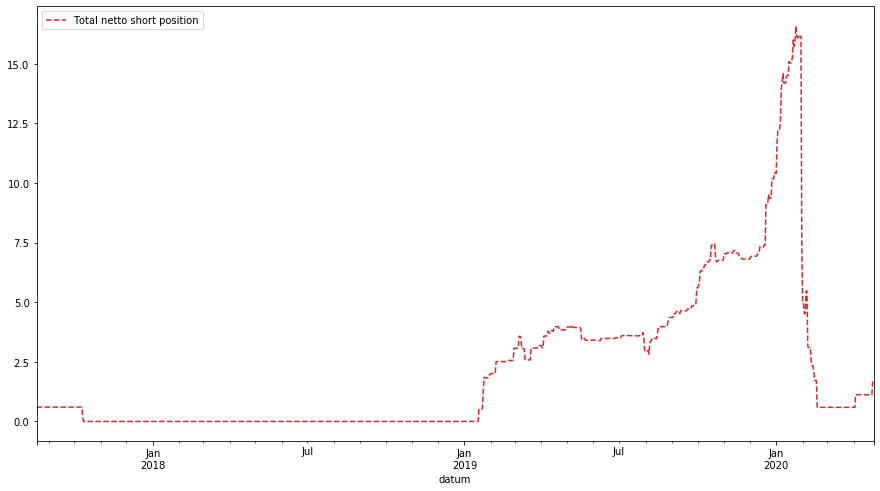

In [77]:
plot_total_short("Just Eat Takeaway.com N.V.")

In [157]:
df.head()

,Positie houder,Naam van de emittent,ISIN,Netto Shortpositie,Positiedatum,datum
0,"BlackRock Institutional Trust Company, Nationa...",OCI N.V.,NL0010558797,0.49,2020-04-28 00:00:00,2020-04-28
1,Citadel Advisors LLC,PostNL N.V.,NL0009739416,0.42,2020-04-28 00:00:00,2020-04-28
2,GLG Partners LP,Wereldhave N.V.,NL0000289213,0.47,2020-04-28 00:00:00,2020-04-28
3,Voleon Capital Management LP,AMG Advanced Metallurgical Group N.V.,NL0000888691,0.48,2020-04-27 00:00:00,2020-04-27
4,BlackRock Investment Management (UK) Limited,Signify N.V.,NL0011821392,0.39,2020-04-24 00:00:00,2020-04-24


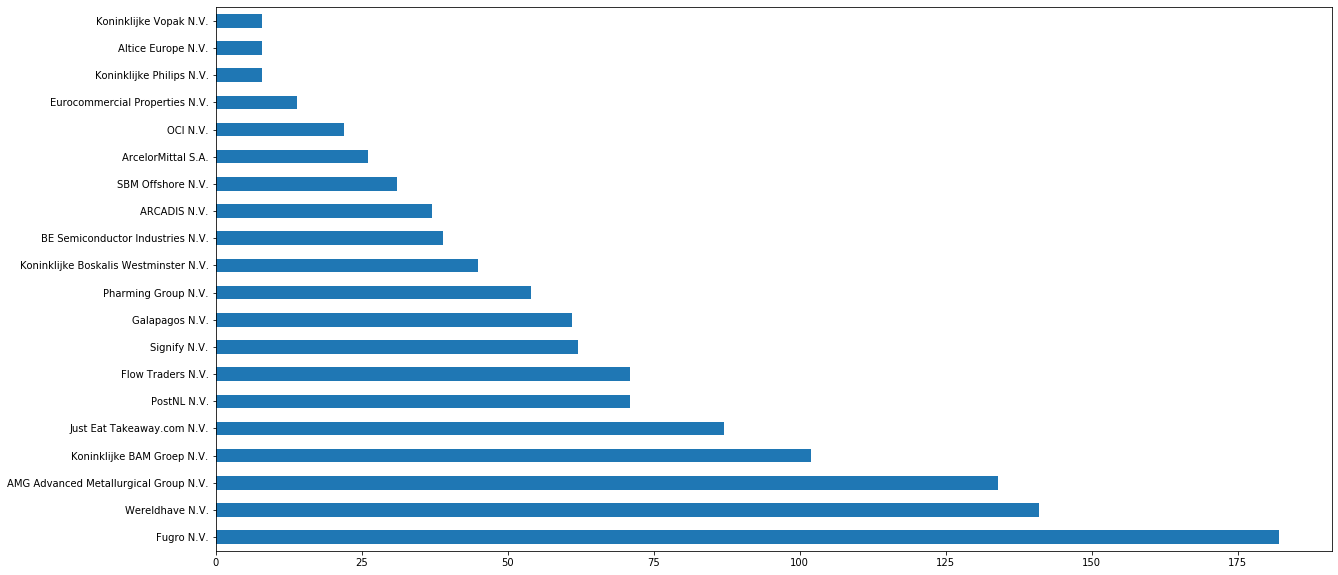

In [159]:
df[(df['datum'] >= '2020-01-01') 
   & (df['datum'] < '2020-05-01')
  ]['Naam van de emittent'].value_counts().head(20).plot(kind='barh', figsize=(20,10))

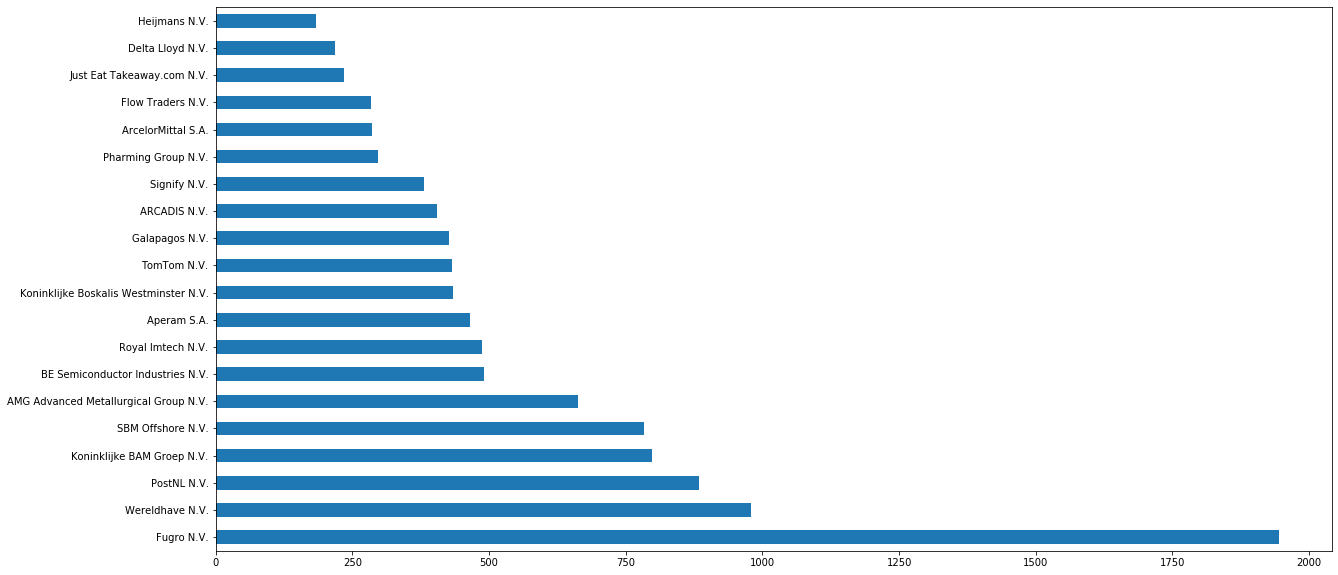

In [160]:
df['Naam van de emittent'].value_counts().head(20).plot(kind='barh', figsize=(20,10))

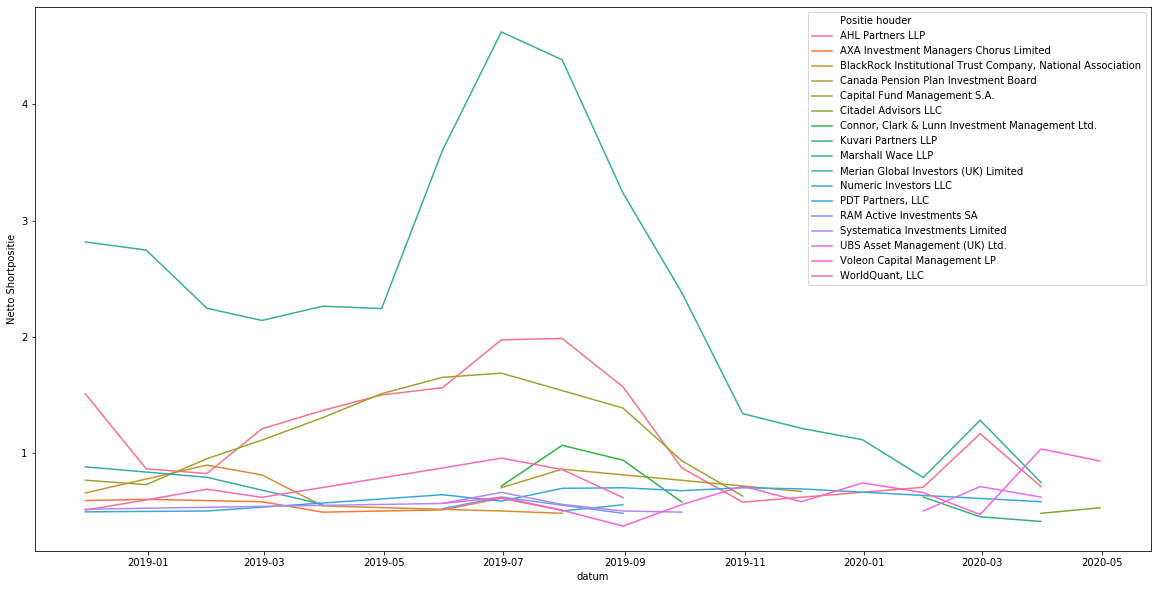

In [165]:
import seaborn as sns

emittent = "PostNL N.V."

df_temp = (
          df[(df['Naam van de emittent'] == "PostNL N.V.") 
        & (df['datum'] >= '2018-11-01') 
        & (df['datum'] < '2020-05-01')
  ].groupby(['Positie houder', pd.Grouper(key="datum", freq='M', )]).mean().reset_index().dropna())

plt.figure(figsize=(20,10))

sns.lineplot(x='datum', y='Netto Shortpositie', hue='Positie houder', data=df_temp)

# sns.lineplot()

In [173]:
from collections import Counter

Counter(df['Naam van de emittent']).most_common(5)

[('Fugro N.V.', 1944),
 ('Wereldhave N.V.', 979),
 ('PostNL N.V.', 884),
 ('Koninklijke BAM Groep N.V.', 798),
 ('SBM Offshore N.V.', 784)]

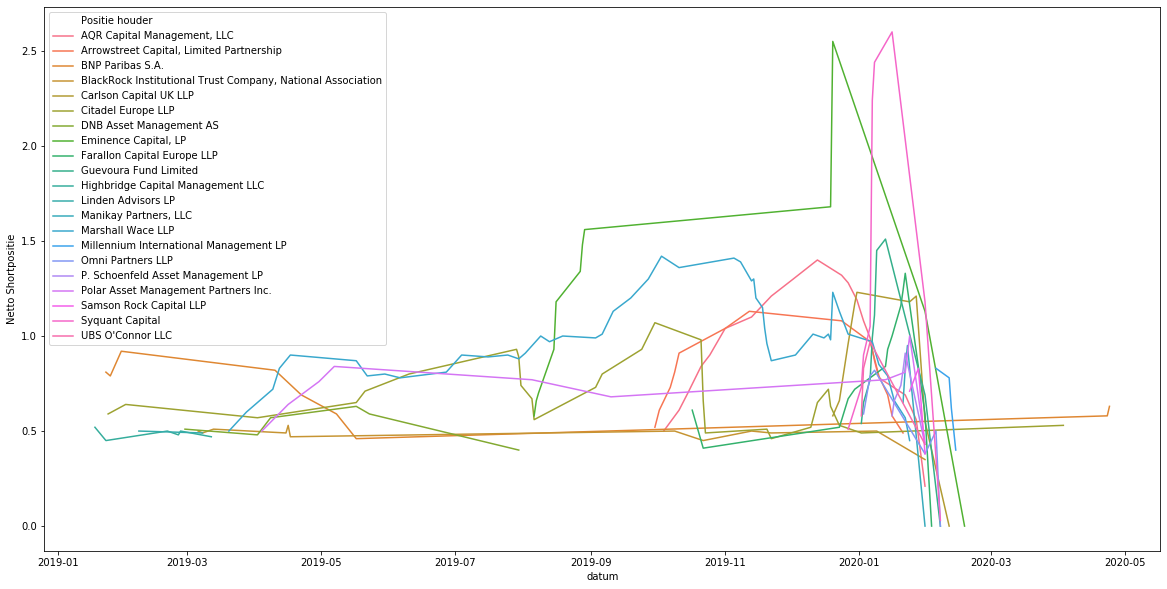

In [168]:
def plot_emittent(emittent):
    df_temp = (
              df[(df['Naam van de emittent'] == emittent) 
        & (df['datum'] >= '2018-11-01') 
        & (df['datum'] < '2020-05-01')
      ]
    .groupby(['Positie houder', pd.Grouper(key="datum", freq='D')]).mean().reset_index().dropna())

    plt.figure(figsize=(20,10))

    sns.lineplot(x='datum', y='Netto Shortpositie', hue='Positie houder', data=df_temp)

plot_emittent("Just Eat Takeaway.com N.V.")

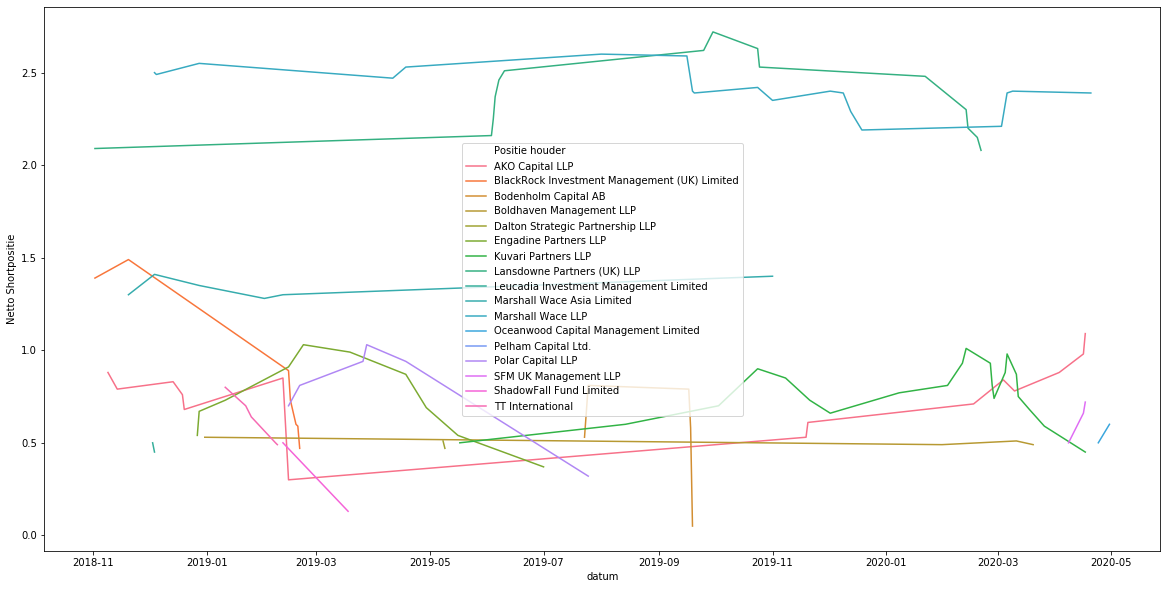

In [169]:
plot_emittent("ARCADIS N.V.")

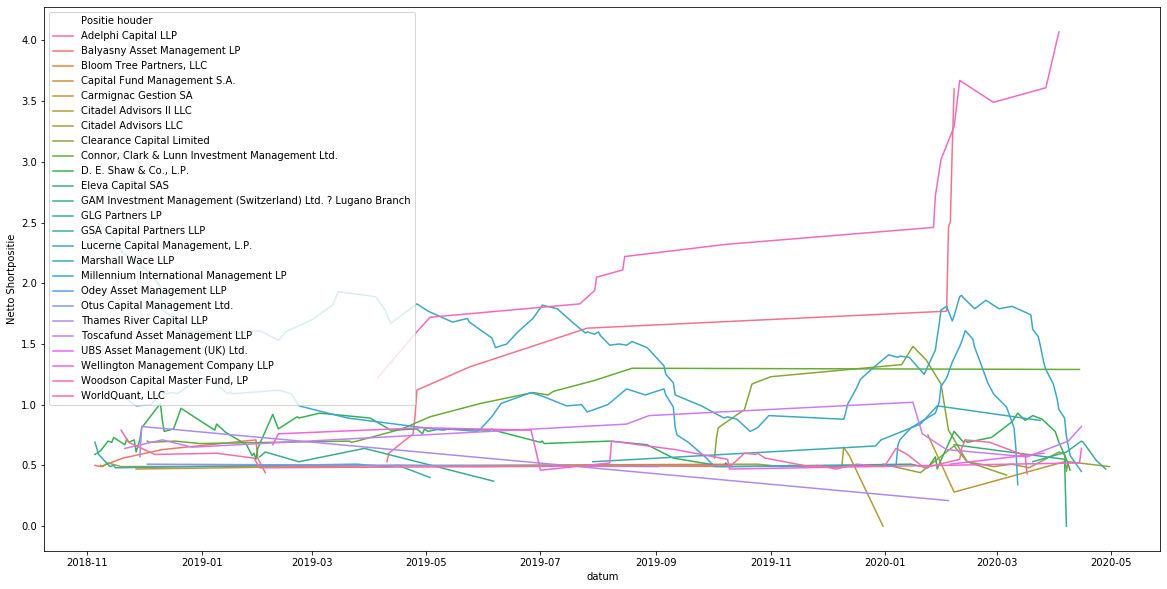

In [170]:
plot_emittent("Wereldhave N.V.")

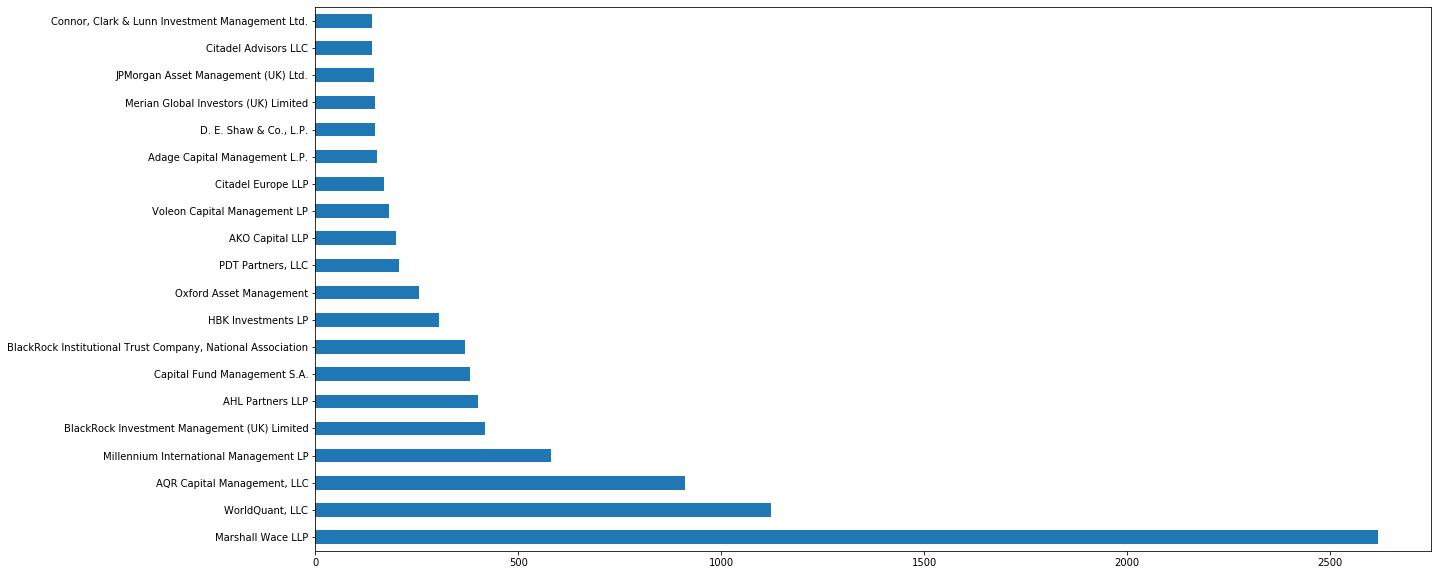

In [171]:
df['Positie houder'].value_counts().head(20).plot(kind='barh', figsize=(20,10))